In [1]:
import os
import glob
import pandas
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import scipy.io.wavfile
from scipy.fftpack import fft
from scipy import signal
import sys
import scipy.io
import IPython.display as ipd

Populating the interactive namespace from numpy and matplotlib


In [31]:
def spectrogram(filepath):
    sr,x = scipy.io.wavfile.read(filepath)
    ## Parameters: 10ms step, 30ms window
    nstep = int(sr * 0.01)
    nwin  = int(sr * 0.03)
    nfft = nwin

    window = np.hamming(nwin)

    ## will take windows x[n1:n2].  generate
    ## and loop over n2 such that all frames
    ## fit within the waveform
    nn = range(nwin, len(x), nstep)

    X = np.zeros( (len(nn), nfft//2) )

    for i,n in enumerate(nn):
        xseg = x[n-nwin:n]
        z = np.fft.fft(window * xseg, nfft)
        X[i,:] = np.log(np.abs(z[:nfft//2]))
        
    return X

def spectrogram_plot(X):
    fig = plt.figure(figsize=(12, 4))
    plt.imshow(X.T, interpolation='nearest',
        origin='lower',
        aspect='auto')

    plt.show()

In [26]:
def log_spectrogram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def scipy_log_spectrogram(filepath):
    samples, sample_rate = librosa.load(filepath)
    freqs, times, spectrogram = log_spectrogram(samples, sample_rate)
    return freqs, times, spectrogram

def scipy_log_spectrogram_plot(freqs, times, spectrogram):
    plt.figure(figsize=(12, 4))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.title('Spectrogram')
    plt.ylabel('Freqs in Hz')
    plt.xlabel('Seconds')

In [18]:
def mel_power_spectrogram(filepath):
    samples, sample_rate = librosa.load(filepath)
    freqs, times, spectrogram = log_spectrogram(samples, sample_rate)
    # Plotting Mel Power Spectrogram
    S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    return log_S

def mel_power_spectrogram_plot(log_S, sample_rate):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel power spectrogram ')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

In [14]:
def delta2_mfcc(filepath):
    samples, sample_rate = librosa.load(filepath)
    freqs, times, spectrogram = log_spectrogram(samples, sample_rate)
    # Plotting Mel Power Spectrogram
    S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    # Plotting MFCC
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    # Let's pad on the first and second deltas while we're at it
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc

def delta2_mfcc_plot(delta2_mfcc):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(delta2_mfcc)
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time')
    plt.title('MFCC')
    plt.colorbar()
    plt.tight_layout()

In [32]:
spec = spectrogram('./test.wav')
print(spec.shape)
print(spec)

16000
(245, 240)
[[ 7.4563539   6.49126312  6.2698123  ...  2.71429566  2.83078468
   2.58331695]
 [ 7.29965456  6.77820613  6.22480287 ...  2.79664505  2.62448248
   2.30133498]
 [ 6.03907543  6.47811701  6.43267988 ...  3.22252639  2.96663755
   3.07085858]
 ...
 [10.54291184  9.69426559  5.19862634 ...  0.96064697  1.91679098
   1.37004053]
 [10.62405559  9.7916364   5.30296062 ...  2.00802607  1.83323881
   1.63822549]
 [10.64332607  9.82787936  5.54671334 ...  1.09741884  1.399698
   0.82188717]]


In [11]:
freqs, times, spec2 = scipy_log_spectrogram('./test.wav')
print(spec2.shape)
print(spec2)

(245, 221)
[[-21.009403 -20.99077  -22.131985 ... -23.02585  -23.02585  -23.02585 ]
 [-21.05023  -21.24717  -22.824091 ... -23.02585  -23.02585  -23.02585 ]
 [-21.885258 -22.810246 -22.677168 ... -23.02585  -23.02585  -23.02585 ]
 ...
 [-15.130006 -15.823912 -22.856066 ... -23.02585  -23.02585  -23.02585 ]
 [-14.954275 -15.639235 -23.003092 ... -23.02585  -23.02585  -23.02585 ]
 [-14.911245 -15.589207 -23.000353 ... -23.02585  -23.02585  -23.02585 ]]


In [12]:
spec3 = mel_power_spectrogram('./test.wav')
print(spec3.shape)
print(spec3)

(128, 107)
[[-67.5094   -65.61574  -63.962746 ... -41.987614 -40.001015 -40.303703]
 [-70.22967  -70.17491  -65.33152  ... -71.4467   -69.73776  -59.14967 ]
 [-69.55138  -66.98341  -67.673645 ... -79.17069  -79.51807  -67.683235]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


In [13]:
spec4 = delta2_mfcc('./test.wav')
print(spec4.shape)
print(spec4)

(13, 107)
[[-2.8766282  -2.8766282  -2.8766282  ...  0.9512667   0.9512667
   0.9512667 ]
 [ 0.46542427  0.46542427  0.46542427 ...  0.9783593   0.9783593
   0.9783593 ]
 [-0.14835267 -0.14835267 -0.14835267 ...  0.42506728  0.42506728
   0.42506728]
 ...
 [-0.56532824 -0.56532824 -0.56532824 ...  0.49975586  0.49975586
   0.49975586]
 [ 0.7747126   0.7747126   0.7747126  ...  0.2904759   0.2904759
   0.2904759 ]
 [ 1.1858875   1.1858875   1.1858875  ...  0.48056626  0.48056626
   0.48056626]]


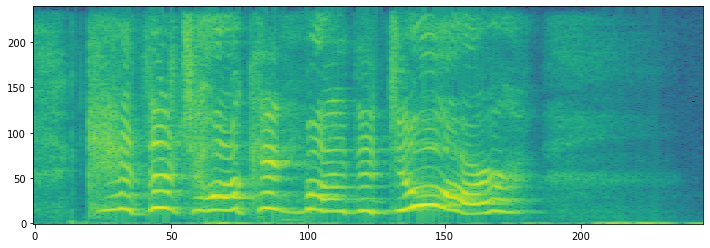

In [30]:
spectrogram_plot(spec)

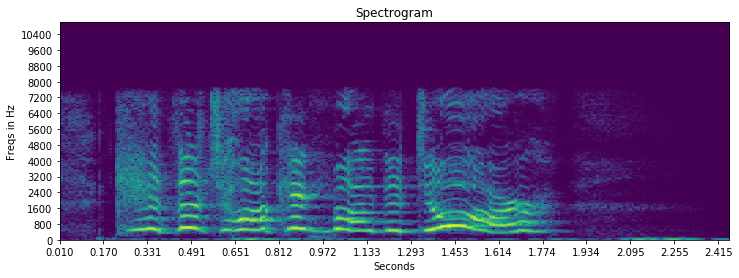

In [27]:
scipy_log_spectrogram_plot(freqs, times, spec2)

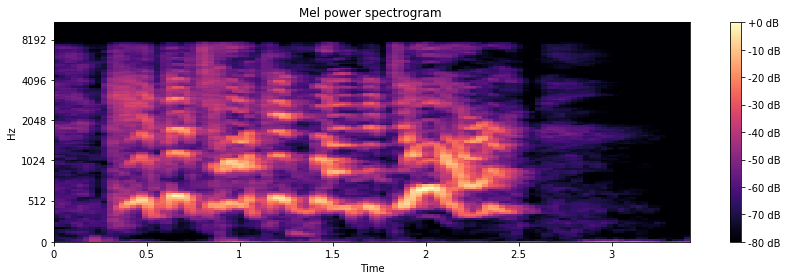

In [19]:
mel_power_spectrogram_plot(spec3, 16000)

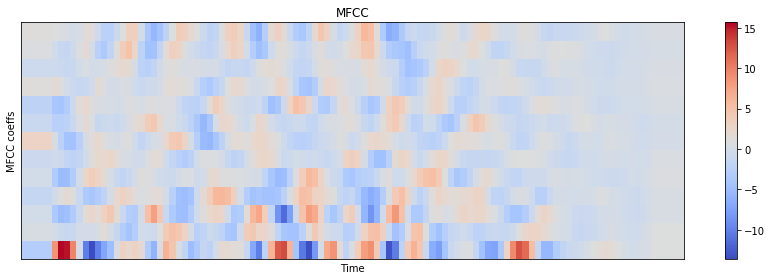

In [15]:
delta2_mfcc_plot(spec4)